## Processing Video Pipeline

I want to start off by stating some assumptions about the existing carrot-identifying image model. Let's assume that this model takes a static image as input, and creates a list of carrots in the image as output. The position of each carrot within the image can be described with a rectangle where the carrot is.

In [ ]:
from matplotlib.patches import Rectangle

carrots = [c1, c2, c3] #list of Rectangle objects

Now, let's look at how to adapt this model to video processing. Each frame of the video can be processed as an individual image, giving a Rectangle list output, but for this application we also want to keep track of the timestamp when the carrot instance was seen, as well as its relation to previous carrot instances. We can create a new data structure to store all this information.

In [ ]:
class VideoCarrot:
    # lastRect: (Rectangle) most recently updated region of carrot
    # lastTimestamp: (float) most recently updated
    # firstRect: (Rectangle) region where carrot was first seen
    # firstTimestamp: (float) Time, in ms from start of the video when carrot was first seen
    # prevCarrot: (VideoCarrot) links this instance to a previous instance
    
    def __init__(self, rect, timestamp):
        self.lastRect = rect
        self.lastTimestamp = timestamp
        self.firstRect = rect
        self.firstTimestamp = timestamp
        
    def update(self, prev):
        self.prevCarrot = prev
        self.firstRect = prev.firstRect
        self.firstTimestamp = prev.firstTimestamp

With this new data structure, we can create two new global lists, one to store all VideoCarrot instances from the most recently processed frame of the video, and another with all VideoCarrot instances from every previous frame. Then while the video is running, the program will get the most recent frame of the video and use it as the input for the image processing model. The output of the image processing model can then be used to create VideoCarrot instances, along with the timestamp of the frame. Each carrot from the new frame is matched with the closest carrot from the previous frame. If a closest carrot was found, the record is updated with the closest carrot. Then, the allCarrots and previousCarrots lists are updated for the next frame.

In [ ]:
allCarrots = [] # all previous VideoCarrots
previousCarrots = [] # VideoCarrots from previous frame

while VideoPlaying:
    timestamp, frame = get_frame()
    carrots = imageModel(frame)
    
    newCarrots = []
    for carrot in carrots:
        newCarrots.append(VideoCarrot(carrot, timestamp))
        
    for carrot in newCarrots:
        #find closest carrot in previousCarrots as closestCarrot, returns null if it cannot be matched
        if closestCarrot != null:
            carrot.update(closestCarrot)
        
    for carrot in previousCarrots:
        allCarrots.append(carrot)
    previousCarrots = newCarrots

This solution will allow us to record every instance of a carrot across a live video feed, although it is not as computationally effecient as it could be. The efficiency of the video processor could be improved if we cut down on the amount of frames that are processed. We can have the program only process every nth frame of video by adding the following code before the image is processed.

In [ ]:
n = 30
timestamp, frame = get_frame()
frameCounter += 1
if frameCounter % n == 0:
    carrots = imageModel(frame)
    ...
    ...

The video processor could also be improved with multithreading, so that different parts of the program could be executed simultaneously, though locks would also need to be used to prevent multiple threads from updating the same lists.

## Titanic Data Classifier

In this notebook, I am going to show the step-by-step process of training and selecting a classification model to determine whether or not passengers aboard the Titanic survived.

The data used will be the training set (train.csv) from ([this](https://www.kaggle.com/competitions/titanic/data?select=train.csv)) Kaggle contest, which contains the following columns:

PassengerId: Unique id number

Survived (Target Vector): 1 = Survived, 2 = Didn't survive

Pclass: Ticket class (1st, 2nd, or 3rd)

Name: Name of passenger

Sex: male or female

Age: Age in years

SibSp: number of siblings or spouses aboard the Titanic

Parch: number of parents or children aboard the Titanic

Ticket: Ticket number

Fare: Passenger fare paid in pounds/shillings

Cabin: cabin number

Embarked: port of embarkation (C=Cherbourg, Q=Queenstown, S=Southhampton)

### Import all necessary libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, f1_score

### Data Inpection

In [30]:
# If the dataset is not already downloaded, use the following link
!curl -L -o titanic.csv https://ucc5f6d121498c4eea8032a4adc5.dl.dropboxusercontent.com/cd/0/inline/CTiiaTVgdAt_wqGTgtiw47DnNPIvUeL-qepKXX92dx5h1W2EecuzD1pT8Xpi_msKDM1z84VxFNuE_7W68c3CZmo_I40SfmeFdmqlSgaNgKNfACk8esy9HGfrMdaVQdeG1tX1CkWv5FV9EDjFsWbtn3fe/file#

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 61194    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 61194  100 61194    0     0  77558      0 --:--:-- --:--:-- --:--:-- 78153


In [2]:
# Load the dataset into a pandas dataframe
titanic_df = pd.read_csv("./titanic.csv")
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
# Get a summary of the dataset with .info
titanic_df.info()
# Here we can see Datatypes of each column and non-null counts, with many columns missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# Show number of unique values in each column to determine which catgorical features can be encoded
titanic_df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

### Data Transformation

Before we can use this data, it needs to be transformed in a few ways

First, features that cannot be numerically encoded and features unique to each entry can be dropped

Then, any missing values are filled in with the most frequent value in the column

Categorical features (Sex and Embarked) are encoded with numerical values

Lastly, all numerical features are scaled based on the unit variance from the mean of each column (this is optional, but generally produces more accurate results

In [5]:
# PassengerId and Name are dropped since they are unique to every entry
# Ticket is also dropped because there are too many unique entries to be encoded
# Cabin has too many enique entries and too many missing values, so it is dropped as well
titanic_df = titanic_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [6]:
# Pipeline is used for all data transformations
tf_pipeline = Pipeline([
    ("imputation", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    ("encoding", OrdinalEncoder()),
    ("scaling", StandardScaler())
]).set_output(transform="pandas")

transform_df = tf_pipeline.fit_transform(titanic_df)
transform_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,-0.789272,0.827377,0.737695,-0.558280,0.490044,-0.473674,-1.247170,0.585954
1,1.266990,-1.566107,-1.355574,0.824465,0.490044,-0.473674,1.451165,-1.942303
2,1.266990,0.827377,-1.355574,-0.197564,-0.504555,-0.473674,-0.918801,0.585954
3,1.266990,-1.566107,-1.355574,0.583988,0.490044,-0.473674,1.194181,0.585954
4,-0.789272,0.827377,0.737695,0.583988,-0.504555,-0.473674,-0.890248,0.585954
...,...,...,...,...,...,...,...,...
886,-0.789272,-0.369365,0.737695,-0.137445,-0.504555,-0.473674,-0.290618,0.585954
887,1.266990,-1.566107,-1.355574,-0.798758,-0.504555,-0.473674,0.680212,0.585954
888,-0.789272,0.827377,-1.355574,-0.377922,0.490044,2.008933,0.366120,0.585954
889,1.266990,-1.566107,0.737695,-0.197564,-0.504555,-0.473674,0.680212,-1.942303


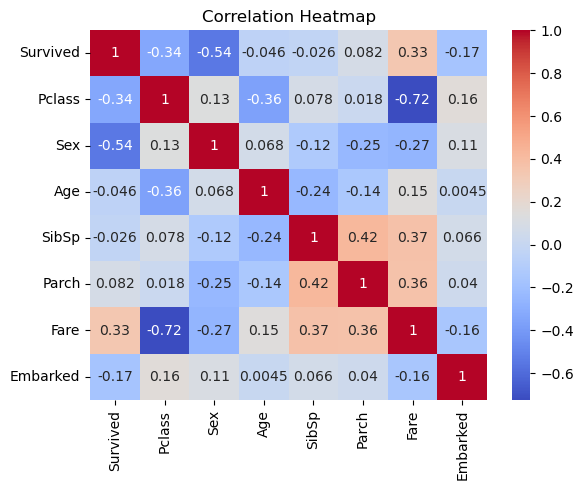

In [7]:
# Create heatmap to visualize correlation between numerical features
sns.heatmap(transform_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [8]:
# Data is split into feature matrix (X) and target vector (y)
X = transform_df.drop(columns = ['Survived'])  # 'X' contains all features except 'Survived'
y = titanic_df["Survived"]

# Create a train_test_split and use 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Evaluating Classifiers and Tuning Hyperparameters

I am going to train three different classification models on this data: Random Forest Classifier, Logistic Regression Classifier, and Support Vector Classifier. For each classifier, I have defined a parameter grid to determine the best parameters for each model. In the interest of keeping computing times low, I have selected three hyperparameters for each model with 2-4 possible values for each parameter.

In [12]:
def evaluate_classifier(name, classifier, param_grid, scoring, X_train, y_train, X_test, y_test):

    print(f'Model name: {name} \n')
    # Create a GridSearchCV instance for the classifier
    grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring=scoring, refit='f1_score')

    # Fit the model
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_

    # Make predictions on the test set
    test_predictions = grid_search.predict(X_test)

    # Calculate accuracy and F1 score on the test set
    accuracy = accuracy_score(y_test, test_predictions)
    f1 = f1_score(y_test, test_predictions)

    # Print best parameters and test results
    print(f"Best Parameters for {name} based on F1:", best_params)
    print("Test Accuracy:", accuracy)
    print("Test F1 Score:", f1)
    print("-----------------------------------")
    
    return test_predictions

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}
    
# Define parameter grids
# Avoid using too many hyperparameters to keep computation times reasonable
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_features': ["sqrt", "log2"],
    'max_depth': [5, 10, 20]
}

param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 'scale', 'auto']
}

# Call the function for each model
pred_rf = evaluate_classifier("Random Forest", RandomForestClassifier(), param_grid_rf, scoring, X_train, y_train, X_test, y_test)
pred_lr = evaluate_classifier("Logistic Regression", LogisticRegression(), param_grid_lr, scoring, X_train, y_train, X_test, y_test)
pred_svm = evaluate_classifier("SVM", SVC(), param_grid_svm, scoring, X_train, y_train, X_test, y_test)

Model name: Random Forest 

Test Accuracy: 0.8379888268156425
Test F1 Score: 0.7913669064748202
Best Parameters for Random Forest based on F1: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
-----------------------------------
Model name: Logistic Regression 

Test Accuracy: 0.7877094972067039
Test F1 Score: 0.736111111111111
Best Parameters for Logistic Regression based on F1: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
-----------------------------------
Model name: SVM 

Test Accuracy: 0.8156424581005587
Test F1 Score: 0.7659574468085106
Best Parameters for SVM based on F1: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
-----------------------------------


Based on these results, the Random Forest Classifier is the most accurate of the three models tested, with max_depth: 10, max_features: 'sqrt', and n_estimators: 100, being the best combination of parameters for this model. The confusion matrices below show the number of correct and incorrect predictions for each model.

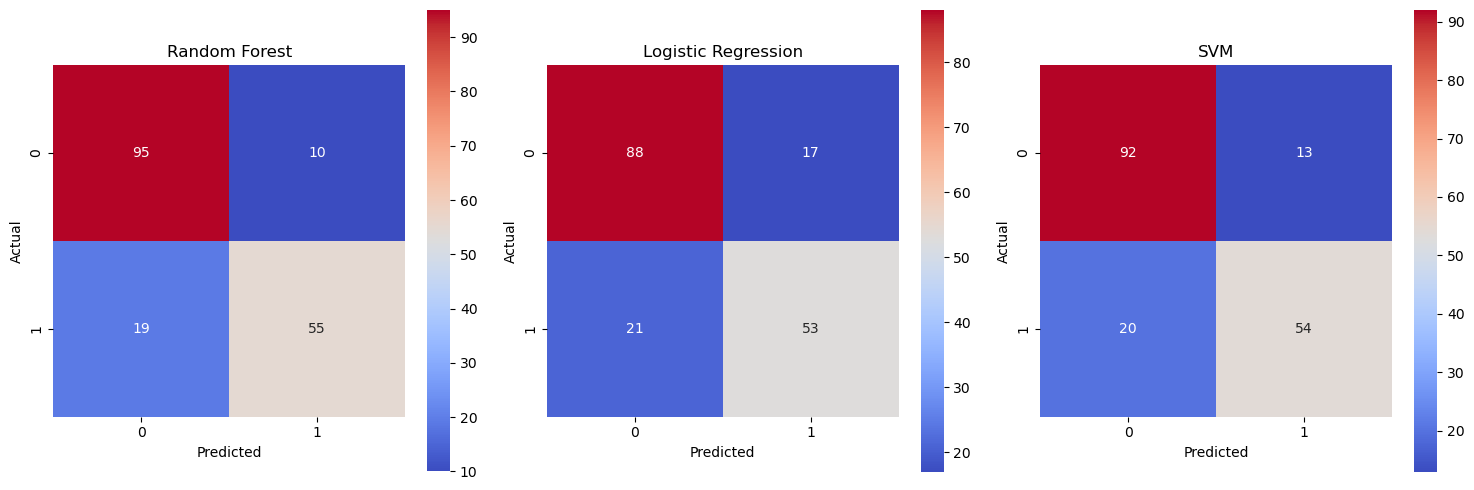

In [16]:
predlist = {'Random Forest': pred_rf, 'Logistic Regression': pred_lr, 'SVM': pred_svm}

#create three confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    cm = confusion_matrix(y_test, list(predlist.values())[i])
    sns.heatmap(cm, square=True, cmap='coolwarm', fmt='d', annot=True, ax = axes[i])
    axes[i].set_title(list(predlist)[i])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()